# Постановка задачи

На предоставленных данных нужно построить модель прогнозирования ухода клиента из банка в ближайшее время.<br>

Необходимо построить модель с хорошим значением F1-меры. У построенной модели значение метрики F1-меры на тестовой выборке должно быть не менее 0.59. <br>

Дополнительно дать оценку значения AUC-ROC в сравнении с F1-мерой.

# Порядок решения задачи

Шаг 0. Импортируем все, что нужно - библиотеки и данные.<br>
Шаг 1. Сделаем предобработку данных.<br>
Шаг 2. Сделаем разбиение на обучающую и тестовую выборку.<br>
Шаг 3. Напишем функции для проведения обучения моделей и визуализации оценок их метрик.<br>
Шаг 4. Проанализируем полученные результаты в т.ч. на вменяемость.<br>
Шаг 5. Напишем краткое аналитическое резюме по выбранной модели.

In [1]:
import pandas as pd
import numpy as np
import random
from statistics import mean
import os
import time
from tqdm import tqdm


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
path_review = '/datasets/Churn.csv'
my_path = '/Users/Ideapad S145/Desktop/Data_Science/06.Модуль Обучение с учителем/Практика/Churn.csv'
if os.path.exists(path_review):
    df = pd.read_csv(path_review, sep=',')
elif os.path.exists(my_path):
    df = pd.read_csv(my_path, sep=',')
else:
    print("Проверьте правильность пути к датасету")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Признаки**<br>
RowNumber — индекс строки в данных<br>
CustomerId — уникальный идентификатор клиента<br>
Surname — фамилия<br>
CreditScore — кредитный рейтинг<br>
Geography — страна проживания<br>
Gender — пол<br>
Age — возраст<br>
Tenure — сколько лет человек является клиентом банка<br>
Balance — баланс на счёте<br>
NumOfProducts — количество продуктов банка, используемых клиентом<br>
HasCrCard — наличие кредитной карты<br>
IsActiveMember — активность клиента<br>
EstimatedSalary — предполагаемая зарплата<br>
**Целевой признак**<br>
Exited — факт ухода клиента

В нашем датасете всего 10 000 записей. Все поля кроме одного Tenure заполненны. В поле Tenure 909 пропущенных значений. В процессе преподготовки данных мы посмотрим, что там пропущено и выясним причину пропусков.

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Привидем названия колонок к правильному написанию

In [5]:
df.columns = ['row_number', 'сustomer_id', 'surname', 'credit_score', 'geography', 'gender', 'age',
       'tenure', 'balance', 'num_of_products', 'has_credcard', 'is_active_member',
       'estimated_salary', 'exited']

Поле RowNumber не нужно поэтому удалим его.

In [6]:
df.head()

,row_number,сustomer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credcard,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [7]:
df.drop(['row_number'], axis=1, inplace=True)

Поле CustomerId больше подойдет под индекс. Проверим уникальность значений в этом поле.

In [8]:
print('длина датасета', len(df))
print('количество уникальных значениий в поле CustomerId', len(df.сustomer_id.unique()))

длина датасета 10000
количество уникальных значениий в поле CustomerId 10000


In [9]:
df.set_index('сustomer_id', inplace=True)

**Посмотрим поле surname**

In [10]:
df.surname.value_counts()

Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Izmailov     1
Bold         1
Bonham       1
Poninski     1
Burbidge     1
Name: surname, Length: 2932, dtype: int64

Это поле по большому счету ни на что не влияет. По нему можно будет попытаться установить семейственность - одна фамилия и при этом два пола, но и это очень все натянуто и неоднозначно. Поэтому лучше его удалить.

In [11]:
df.drop(['surname'], axis=1, inplace=True)

**Посмотрим поле credit_score**

Это поле с оценками кредитного скоринга. Значениие его дискретный набор трехзначных чисел. Если набор небольшой, то это поле можно перевести категориальный тип. Если много, то оставим числовым.

In [12]:
print('Количество уникальных значений', len(df.credit_score.unique()))

Количество уникальных значений 460


Это довольно много для категорий, поэтому оставим его числовым.

In [13]:
df.credit_score.describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: credit_score, dtype: float64

Посмотрим распределение значений кредитного скоринга в нашем датасете.

Text(0.5, 1.0, 'Ящик с усами оценок кредитного скоринга')

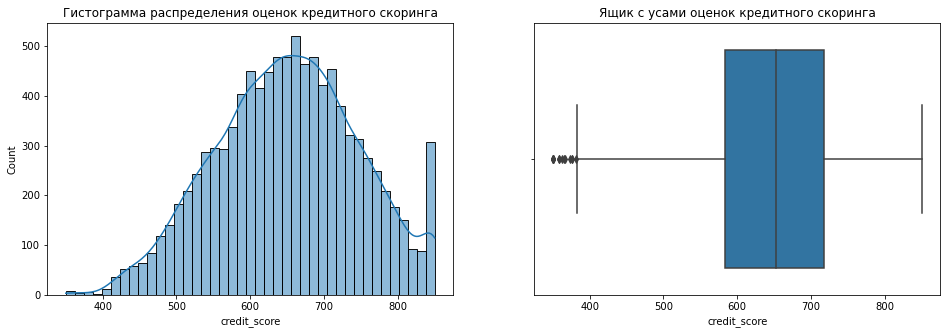

In [14]:
fig = plt.figure(figsize=(16,5))
ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)
sns.histplot(x=df.credit_score, kde=True, ax=ax_1)
ax_2 = sns.boxplot(x=df.credit_score, ax=ax_2)
ax_1.set_title('Гистограмма распределения оценок кредитного скоринга', fontsize=12)
ax_2.set_title('Ящик с усами оценок кредитного скоринга', fontsize=12)

Почти идеальное норамальное распределение, но всю красоту портит правая сторона в которой скопилось большое количество клиентов с максимальным скорингом 850. На боксплоте немного выбросов слева. Оставим как есть.

**Посмотрим поле geography**

In [15]:
df.geography.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

Всего три страны. Это чисто категориальное поле.<br>
Посмотрим распределение значений по странам-категориям.

In [16]:
df.geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

Соотношение записей среди категорий Франция, Германия и Испания = 2:1:1

**Посмотрим поле Gender**

In [17]:
df.gender.value_counts(normalize=True)

Male      0.5457
Female    0.4543
Name: gender, dtype: float64

Хорошо, что нет третьего пола. Объекты датасета распределены примерно поровну относительно половой принадлежности. Это хорошо.

**Посмотрим поле age**

In [18]:
df.age.value_counts()

37    478
38    477
35    474
36    456
34    447
     ... 
92      2
82      1
88      1
85      1
83      1
Name: age, Length: 70, dtype: int64

In [19]:
df.age.describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'Ящик с усами распределения клиентов по возрасту')

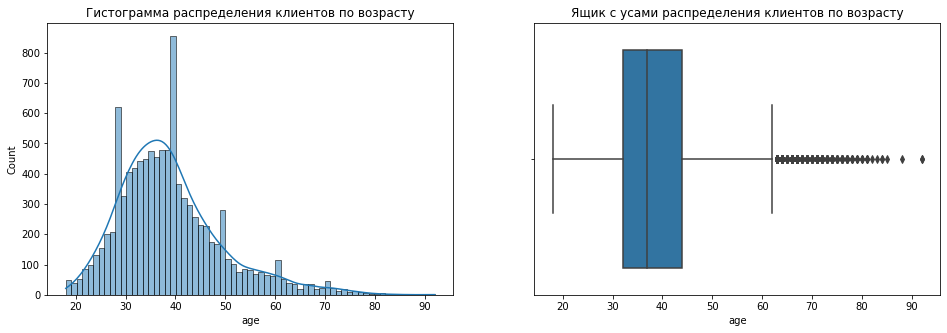

In [20]:
fig = plt.figure(figsize=(16,5))
ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)
sns.histplot(x=df.age, kde=True, ax=ax_1)
ax_2 = sns.boxplot(x=df.age, ax=ax_2)
ax_1.set_title('Гистограмма распределения клиентов по возрасту', fontsize=12)
ax_2.set_title('Ящик с усами распределения клиентов по возрасту', fontsize=12)

Большой правый хвост на гистограмме и выборсы справа на боксплоте говорит о том, что довольно много уникальных значений данного признака. Этот факт может негативно повлиять на обучение модели. Возможно здесь имеет смысл перейти от значений возраста к возрастным категориям с небольшим шагом - 5 лет. Пока оставляем как есть, но если модель будет плохо учиться, то сделаем переход от числового признака к категориальному.

**Посмотрим поле tenure** 

In [21]:
df.tenure.unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

У нас 909 объектов без признака tenure. Значения данного признака распределены равномерно.

Text(0.5, 1.0, 'Ящик с усами tenure')

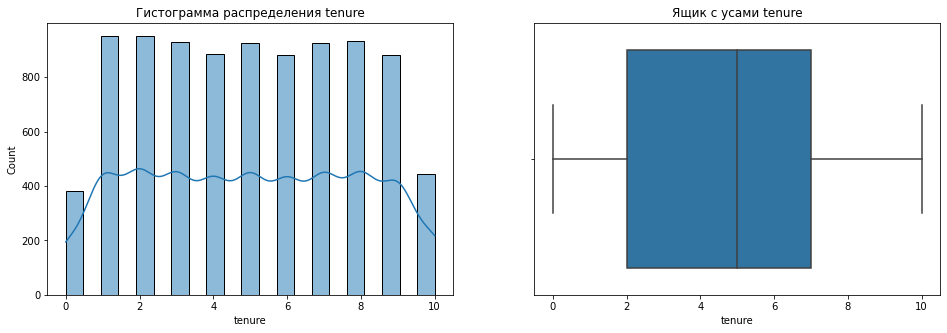

In [22]:
fig = plt.figure(figsize=(16,5))
ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)
sns.histplot(x=df.tenure, kde=True, ax=ax_1)
ax_2 = sns.boxplot(x=df.tenure, ax=ax_2)
ax_1.set_title('Гистограмма распределения tenure', fontsize=12)
ax_2.set_title('Ящик с усами tenure', fontsize=12)

Если мы сделаем замену пропущенных значений на медиану или среднее (они почти равны), то получим нарушение истинного равномерного распределения, что скажется на обучение модели. <br>
Есть два варианта:
1. Сделать модель предсказываюшую сколько лет клиент обслуживается в банке.
2. Удалить объекты с пропуском данного признака.

Данных пока остаточно и мы пока идем по простому вариант, поэтому удалим все объекты с пропуском значений.

In [23]:
df.dropna(inplace=True)

**Посмотрим поле Balance**          

In [24]:
df.balance.describe()

count      9091.000000
mean      76522.740015
std       62329.528576
min           0.000000
25%           0.000000
50%       97318.250000
75%      127561.890000
max      250898.090000
Name: balance, dtype: float64

Text(0.5, 1.0, 'Ящик с усами остатков на счетах')

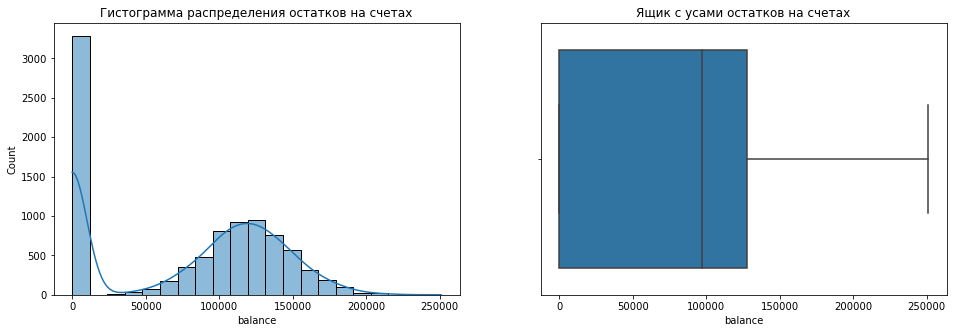

In [25]:
fig = plt.figure(figsize=(16,5))
ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)
sns.histplot(x=df.balance, kde=True, ax=ax_1)
ax_2 = sns.boxplot(x=df.balance, ax=ax_2)
ax_1.set_title('Гистограмма распределения остатков на счетах', fontsize=12)
ax_2.set_title('Ящик с усами остатков на счетах', fontsize=12)

Если бы не объекты с нулевым балансом и небольшая группка с большими остатками на счетах, то было бы идеальное нормальное распределение. С этим признаком все хорошо.

**Посмотрим поле num_of_products**

In [26]:
df.num_of_products.unique()

array([1, 3, 2, 4], dtype=int64)

Несмотря на то, что формально это количественный признак по существу это категориальный признак выраженный сразу числовым кодом. Нельзя иметь 2,5 продукта и нельзя иметь 50 продуктов (в реальной жизни).

Посмотрим распределение объектов по количеству продуктов.

In [27]:
df.num_of_products.value_counts()

1    4617
2    4184
3     234
4      56
Name: num_of_products, dtype: int64

Количество пользуемых продуктов обратно пропорционально количеству клиентов.

**Посмотрим поле has_credcard**

In [28]:
df.has_credcard.unique()

array([1, 0], dtype=int64)

In [29]:
df.has_credcard.value_counts()

1    6409
0    2682
Name: has_credcard, dtype: int64

Отношение 2,3:1 в пользу клиентов с кредитной картой.

**Посмотрим поле IsActiveMember**

In [30]:
df.is_active_member.unique()

array([1, 0], dtype=int64)

In [31]:
df.is_active_member.value_counts()

1    4687
0    4404
Name: is_active_member, dtype: int64

Клиенты распределены поровну на активных и неактивных.

**Посмотрим поле estimated_salary**

In [32]:
df.estimated_salary.describe()

count      9091.000000
mean     100181.214924
std       57624.755647
min          11.580000
25%       51227.745000
50%      100240.200000
75%      149567.210000
max      199992.480000
Name: estimated_salary, dtype: float64

Text(0.5, 1.0, 'Ящик с усами оценок доходов')

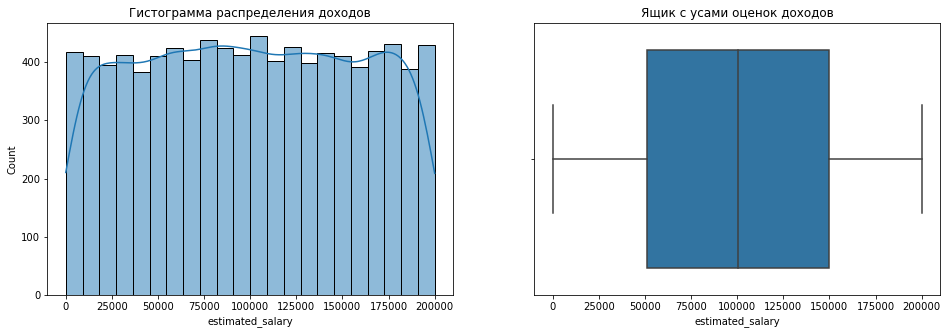

In [33]:
fig = plt.figure(figsize=(16,5))
ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)
sns.histplot(x=df.estimated_salary, kde=True, ax=ax_1)
ax_2 = sns.boxplot(x=df.estimated_salary, ax=ax_2)
ax_1.set_title('Гистограмма распределения доходов', fontsize=12)
ax_2.set_title('Ящик с усами оценок доходов', fontsize=12)

Идельное равномерное распределение клиентов по уровню дохода. Просто всех категорий по уровню доходов поровну.

**Посмотрим поле Exited**

In [34]:
df.exited.value_counts()

0    7237
1    1854
Name: exited, dtype: int64

Налицо дисбаланс класса целевого признака - почти 4:1 "нули" к "единицам"

**Резюме:**<br>
Данные почти хорошие. Местами наблюдается дисбаланс класса по признакам, а также довольно существенный дисбаланс по целевому признаку. В рамках предобработки удалены были 909 объектов (9% выборки) с отсутствующими данными по длительности нахождения клиента на обслуживании в банке. В целом данные по структуре и распределению неплохие. Дальше будет анализироваться зависимость данных между собой.

# Оценка зависимости данных, кодировка и нормализация

Составим матрицу корреляции Пирсона между следующими признаками:<br>
- Кредитный рейтинг;
- Пол;
- Возраст;
- Срок обслуживания в банке;
- Баланс счета;
- Количество продуктов на клиенте;
- Наличие кредитной карты;
- Активность клиента;
- Доход;
- Целевой признак.

In [35]:
# Составим список признаков для матрицы корреляции
# перед этим закодируем поле gender 
df.gender = [1 if x=='Male' else 0 for x in df.gender] 

In [36]:
data = ['credit_score', 'age', 'gender', 'tenure', 'balance',
       'num_of_products', 'has_credcard', 'is_active_member',
       'estimated_salary', 'exited']

In [37]:
df[data].corr()

,credit_score,age,gender,tenure,balance,num_of_products,has_credcard,is_active_member,estimated_salary,exited
credit_score,1.000000,-0.004504,-0.008547,-0.000062,0.002804,0.011090,-0.003937,0.030947,0.005182,-0.023950
age,-0.004504,1.000000,-0.025631,-0.013134,0.031481,-0.031877,-0.014129,0.082269,-0.007037,0.283017
gender,-0.008547,-0.025631,1.000000,0.012634,0.018030,-0.025176,0.006016,0.025019,-0.002658,-0.110450
tenure,-0.000062,-0.013134,0.012634,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
balance,0.002804,0.031481,0.018030,-0.007911,1.000000,-0.301858,-0.019055,-0.003285,0.014351,0.117218
num_of_products,0.011090,-0.031877,-0.025176,0.011979,-0.301858,1.000000,0.005805,0.009084,0.013990,-0.050271
has_credcard,-0.003937,-0.014129,0.006016,0.027232,-0.019055,0.005805,1.000000,-0.008810,-0.006136,-0.005411
is_active_member,0.030947,0.082269,0.025019,-0.032178,-0.003285,0.009084,-0.008810,1.000000,-0.020049,-0.155062
estimated_salary,0.005182,-0.007037,-0.002658,0.010520,0.014351,0.013990,-0.006136,-0.020049,1.000000,0.016029
exited,-0.023950,0.283017,-0.110450,-0.016761,0.117218,-0.050271,-0.005411,-0.155062,0.016029,1.000000


Возможные зависимости между признаками:
1. Баланс счета и уровень проникновения в клиента корреляция -0,30.
2. Возраст и целевой признак корреляция 0,28.
Корреляции между данными признаками довольно слабая, но все же она может влиять на будущую модель классификации.
Первую корреляцию можно интерпретировать так - чем больше у клиента денег на счете тем больше продуктов - дебетовая карта, депозит и пр. (список продуктов неизвестен).
Вторую корреляцию можно интепретировать так  - чем страше клиент, тем меньше он нуждается в услугах банка, а кто-то и еще умирает при этом.<br>

Есть еще очень слабенькая корреляция между активнстью клиента и целевым признаком.

**Резюме.**<br>
Данные хорошие, с четкой структурой распределения, а также с минимальными выбросами. Данные готовы к этапу разделения на выборки для обучения моделей.

# Кодировка полей с категориальными данными

Сделаем кодировку категориальных признаков - страна клиента. Кодировку сделаем с помощью OneHotEncoder с удалением зависимого признака

In [38]:
df_ohe = pd.get_dummies(df, columns=['geography'], drop_first=True)

In [39]:
df_ohe.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_credcard,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain
сustomer_id,,,,,,,,,,,,
15634602,619,0,42,2.0,0.00,1,1,1,101348.88,1,0,0
15647311,608,0,41,1.0,83807.86,1,0,1,112542.58,0,0,1
15619304,502,0,42,8.0,159660.80,3,1,0,113931.57,1,0,0
15701354,699,0,39,1.0,0.00,2,0,0,93826.63,0,0,0
15737888,850,0,43,2.0,125510.82,1,1,1,79084.10,0,0,1


На этом пока остановимся и перейдем к разбиеню выборки на обучающую, валидационную и тестовую

# Разбиение датасета для обучения, валидации и теста, а также нормализация полей с числовыми данными 

Напишем функцию, которая на входе получает датасет, а на выходе выдает обучающую и тестовую выборки. <br> 
Валидационную выборку делать не будем, т.к. будем пользоваться подборщиком гиперпараметров, который внутри себя будет использовать кросс-валидацию.  

In [42]:
# функция, которая делит выборк на обучающую и тестовую
def selection(features, target, random_state, frac, stratify):
    return train_test_split(features, target, test_size=frac,  random_state=random_state, stratify=stratify)

In [43]:
target = df_ohe.exited
features = df_ohe.drop('exited', axis=1)

features_train, features_test, target_train, target_test = selection(features, target, 12345, 0.2, target)
features_train, features_valid, target_train, target_valid = selection(features_train, target_train, 12345, 0.25, target_train)
features_train.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_credcard,is_active_member,estimated_salary,geography_Germany,geography_Spain
сustomer_id,,,,,,,,,,,
15794566,678,0,28,4.0,0.00,2,1,1,144423.17,0,0
15634936,735,1,41,7.0,179904.00,1,1,1,137180.95,0,0
15584897,639,0,31,3.0,98360.03,1,0,0,20973.80,0,0
15701121,521,1,38,5.0,110641.18,1,0,1,136507.69,0,0
15684294,735,1,50,2.0,0.00,2,0,1,147075.69,0,0


Посмотрим размеры полученных выборок в результате нашего разбиения.

In [44]:
print('Размер обучающей выборки =', features_train.shape)
print('Размер валидационной выборки =', features_valid.shape)
print('Размер тестовой выборки =', features_test.shape)

Размер обучающей выборки = (5454, 11)
Размер валидационной выборки = (1818, 11)
Размер тестовой выборки = (1819, 11)


Сделаем список признаков, которые нужно нормализовать и сделаем нормировку количественных признаков

In [45]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

# Определение функций необходимых для проведения обучения моделей

In [46]:
# функция, которая вычисляет метрики и возвращает список метрик и модель
def result_model(model, features, target):
    return [model.score(features, target), 
            precision_score(target, model.predict(features)),
            recall_score(target, model.predict(features)),
            roc_auc_score(target, model.predict_proba(features)[:,1]),
            f1_score(target, model.predict(features))]

# функция подборщик моделей логистической регрессии
def LR_model_f1(features_train, target_train, class_weight):
    logistic = LogisticRegression(solver='saga', tol=0.00001, max_iter=1000, random_state=12345, class_weight=class_weight)
    parametrs = dict(C=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                     penalty=['l2', 'l1'])
    clf = RandomizedSearchCV(logistic, 
                             parametrs, 
                             random_state=12345, 
                             cv=5, 
                             scoring='f1',
                             n_jobs=-1)
    search = clf.fit(features_train, target_train)
    return search.best_estimator_

# функция подборщик моделей случайного леса
def RFC_model_f1(features_train, target_train, class_weight):
    RandomForest = RandomForestClassifier(random_state=12345, class_weight=class_weight)
    parametrs = { 'n_estimators': range (20, 1001, 20),
                  'max_depth': range (1, 10, 1) }
    clf = RandomizedSearchCV(RandomForest, 
                             parametrs, 
                             random_state=12345, 
                             cv=5, 
                             scoring='f1', 
                             n_jobs=-1)
    search = clf.fit(features_train, target_train)
    return search.best_estimator_

# функция подборщик моделей градиентного бустинга
def GBC_model_f1(features_train, target_train):
    parametrs = dict(n_estimators = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                     max_depth = [2, 3], 
                     learning_rate = np.arange(0.1, 0.9, 0.1))
    GradientBoosting = GradientBoostingClassifier(random_state=12345)
    clf = RandomizedSearchCV(GradientBoosting, 
                             parametrs, 
                             random_state=12345, 
                             cv=5, 
                             scoring='f1', 
                             n_jobs=-1)
    search = clf.fit(features_train, target_train)
    return search.best_estimator_

# функция, которая выводит на экран результаты отработки моделей на обучающей и тестовой выборки
def table_best(LR_model, RFC_model, GBC_model, features_train, target_train, features_test, target_test, param):

    best_train = pd.DataFrame([result_model(LR_model, features_train, target_train),
                         result_model(RFC_model, features_train, target_train),
                         result_model(GBC_model, features_train, target_train)],
                        columns=['accuracy', 'precision', 'recall', 'AUC ROC метрика', 'F1_score'],
                        index=['LogisticRegression', 'RandomForest', 'GradientBoosting'])
    best_test = pd.DataFrame([result_model(LR_model, features_test, target_test),
                         result_model(RFC_model, features_test, target_test),
                         result_model(GBC_model, features_test, target_test)],
                        columns=['accuracy', 'precision', 'recall', 'AUC ROC метрика', 'F1_score'],
                        index=['LogisticRegression', 'RandomForest', 'GradientBoosting'])
    print()
    print('Результаты работы подборщиков моделей по метрике F1 на обучающей выборке')
    print(best_train if param!='balanced' else best_train.drop('GradientBoosting', axis=0))
    print()
    print('Результаты работы подборщиков моделей по метрике F1 на валидационной выборке')
    print(best_test if param!='balanced' else best_test.drop('GradientBoosting', axis=0))
    
# функция, которая делает upsampling для обучающей выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

# функция, которая делает downsampling для обучающей выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

# функция которая делает таблицу сравнений метрик примитивных и рандомных моделей с полученной моделью
def adequacy(model, features, target):
    predict_const = [0]*(len(target)-1) + [1] # добавил одну 1, чтобы сработали функции по расчету метрик
    predict_random = [int(random.randint(0, 1) == target[i]) for i in target.index]

    data = [[accuracy_score(target, predict_const), accuracy_score(target, predict_random),
             accuracy_score(target, model.predict(features))],
            [precision_score(target, predict_const), precision_score(target, predict_random),
             precision_score(target, model.predict(features))],
            [recall_score(target, predict_const), recall_score(target, predict_random),
             recall_score(target, model.predict(features))],
            [f1_score(target, predict_const), f1_score(target, predict_random),
             f1_score(target, model.predict(features))]]

    return pd.DataFrame(data,
                        columns=['predict_const', 'predict_random', 'best_model_ML'],
                        index=['accuracy_score', 'precision_score', 'recall_score', 'f1_score'])

# Сделаем первую иттерацию по созданию моделей

Согласно заданию мы должны в первой иттерации посчитать все как есть без оптимизационных действий

In [47]:
best_LR_model_f1_common = LR_model_f1(features_train, target_train, None)
best_RFC_model_f1_common = RFC_model_f1(features_train, target_train, None)
best_GBC_model_f1_common = GBC_model_f1(features_train, target_train)
table_best(best_LR_model_f1_common, 
           best_RFC_model_f1_common, 
           best_GBC_model_f1_common, 
           features_train, target_train, features_valid, target_valid,
           'common')


Результаты работы подборщиков моделей по метрике F1 на обучающей выборке
                    accuracy  precision    recall  AUC ROC метрика  F1_score
LogisticRegression  0.809681   0.601093  0.197842         0.767384  0.297700
RandomForest        0.895673   0.934400  0.525180         0.944447  0.672424
GradientBoosting    0.959296   0.963542  0.831835         0.986812  0.892857

Результаты работы подборщиков моделей по метрике F1 на валидационной выборке
                    accuracy  precision    recall  AUC ROC метрика  F1_score
LogisticRegression  0.804730   0.566667  0.183288         0.757908  0.276986
RandomForest        0.864136   0.826316  0.423181         0.866617  0.559715
GradientBoosting    0.842134   0.659091  0.469003         0.845225  0.548031


In [48]:
print('Лучшая модель')
print(best_RFC_model_f1_common)

Лучшая модель
RandomForestClassifier(max_depth=9, random_state=12345)


**Резюме**<br>
Лучший результат у RFC с параметрами (max_depth=9, random_state=12345). Но стоит отметить, что на валидационной выборке лучшая модель показала не самые лучшие результаты и не проходит под требования, что f1-score >=0.59 на тестовой выборке.<br>
Без учета баланса классов целевого признака полученные модели показыват неудовлетворительные результаты метрики F1-score.


# Оптимизация выборок и моделей

Попробуем устранить дисбаласн классов целевого признака<br>
В рамках оптимизации сделаем следующее:<br>
1. Обучим наши модели с учетом веса целевого признака
2. Сделаем вариант с upsampling обучающей выборки
3. Сделаем вариант с downsampling обучающей выборки.

**1й вариант. Обучение с учетом параметра веса целевого признака**

In [49]:
best_LR_model_f1_balanсed = LR_model_f1(features_train, target_train, 'balanced')
best_RFC_model_f1_balanсed = RFC_model_f1(features_train, target_train, 'balanced')
table_best(best_LR_model_f1_balanсed, 
           best_RFC_model_f1_balanсed, 
           best_GBC_model_f1_common, 
           features_train, target_train, features_valid, target_valid,
           'balanced')


Результаты работы подборщиков моделей по метрике F1 на обучающей выборке
                    accuracy  precision    recall  AUC ROC метрика  F1_score
LogisticRegression  0.715622   0.389754  0.697842         0.770921  0.500161
RandomForest        0.897323   0.716641  0.821043         0.953265  0.765298

Результаты работы подборщиков моделей по метрике F1 на валидационной выборке
                    accuracy  precision    recall  AUC ROC метрика  F1_score
LogisticRegression  0.710671   0.384844  0.698113          0.76155  0.496169
RandomForest        0.833883   0.586035  0.633423          0.86584  0.608808


In [50]:
print('Лучшая модель')
print(best_RFC_model_f1_balanсed)

Лучшая модель
RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=320,
                       random_state=12345)


**Резюме**
Лучший результат у RFC с параметрами (class_weight='balanced', max_depth=9, n_estimators=320, random_state=12345). На валидационной выборке лучшая модель показала также  лучший результат f1-score = 0.609.<br>
Учли веса и значения метрик улучшилось и появилась модель удовлетворяющая нашим требованиям.

**2й вариант. Upsampling обучающей выборки**

In [51]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
print('Структура upsampling')
print(target_upsampled.value_counts())

best_LR_model_f1_upsampling = LR_model_f1(features_upsampled, target_upsampled, None)
best_RFC_model_f1_upsampling = RFC_model_f1(features_upsampled, target_upsampled, None)
best_GBC_model_f1_upsampling = GBC_model_f1(features_upsampled, target_upsampled)

table_best(best_LR_model_f1_upsampling,
           best_RFC_model_f1_upsampling,
           best_GBC_model_f1_upsampling,
           features_upsampled, target_upsampled, features_valid, target_valid,
           'upsampling')

Структура upsampling
1    4448
0    4342
Name: exited, dtype: int64

Результаты работы подборщиков моделей по метрике F1 на обучающей выборке
                    accuracy  precision    recall  AUC ROC метрика  F1_score
LogisticRegression  0.709784   0.715226  0.708633         0.771004  0.711914
RandomForest        0.881115   0.891960  0.870504         0.954370  0.881101
GradientBoosting    0.990899   0.984043  0.998201         0.999367  0.991071

Результаты работы подборщиков моделей по метрике F1 на валидационной выборке
                    accuracy  precision    recall  AUC ROC метрика  F1_score
LogisticRegression  0.705171   0.380608  0.708895         0.761756  0.495292
RandomForest        0.814081   0.534737  0.684636         0.866120  0.600473
GradientBoosting    0.820132   0.555276  0.595687         0.831537  0.574772


In [52]:
print('Лучшая модель')
print(best_RFC_model_f1_upsampling)

Лучшая модель
RandomForestClassifier(max_depth=9, n_estimators=320, random_state=12345)


**Резюме**<br>
Лучший результат у RFC с параметрами (max_depth=9, n_estimators=320, random_state=12345). На валидационной выборке лучшая модель показала удовлетворительные результаты f1-score = 0.60.<br>
Upsampling тоже сработал в части учета баланса классов целевого признака. 

**Третий вариант. Downsampling**

In [53]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
print('Структура Downsampling')
print(target_downsampled.value_counts())

best_LR_model_f1_downsampled = LR_model_f1(features_downsampled, target_downsampled, None)
best_RFC_model_f1_downsampled = RFC_model_f1(features_downsampled, target_downsampled, None)
best_GBC_model_f1_downsampled = GBC_model_f1(features_downsampled, target_downsampled)
table_best(best_LR_model_f1_downsampled, 
           best_RFC_model_f1_downsampled, 
           best_GBC_model_f1_downsampled, 
           features_downsampled, target_downsampled, features_valid, target_valid,
           'downsampling')

Структура Downsampling
1    1112
0    1086
Name: exited, dtype: int64

Результаты работы подборщиков моделей по метрике F1 на обучающей выборке
                    accuracy  precision    recall  AUC ROC метрика  F1_score
LogisticRegression  0.709281   0.716377  0.704137         0.768019  0.710204
RandomForest        0.906733   0.935639  0.875899         0.972515  0.904784
GradientBoosting    0.981347   0.981998  0.981115         0.996497  0.981556

Результаты работы подборщиков моделей по метрике F1 на валидационной выборке
                    accuracy  precision    recall  AUC ROC метрика  F1_score
LogisticRegression  0.701870   0.376266  0.700809         0.761047  0.489642
RandomForest        0.784928   0.481818  0.714286         0.862744  0.575461
GradientBoosting    0.729923   0.410714  0.743935         0.824638  0.529243


In [54]:
print('Лучшая модель')
print(best_RFC_model_f1_downsampled)

Лучшая модель
RandomForestClassifier(max_depth=9, random_state=12345)


**Резюме**<br>
Лучший результат у RFC с параметрами (max_depth=9, random_state=12345). Но стоит отметить, что на валидационной выборке лучшая модель показала не самые лучшие результаты и не проходит под требования, что f1-score >=0.59 на тестовой выборке.<br>
Downsampling не сработал в части учета баланса классов целевого признака. 

**Общее резюме после наших экспериментов с устранение дисбаланса классов целевого признака - лучшая модель на валидационной выборке RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=320, random_state=12345) обученная на обычной обучающей выборке с учетом баланса весов.**

# Проверка адекватности

Константная модель - модель, решением которой является доминирующий признак и в нашем случае "0".<br>
Рандомная модель - модель решением, которой случайный выбор между "0" и "1".<br>
Сравним ее с нашей лучше моделью.

In [55]:
display(adequacy(best_RFC_model_f1_balanсed, features_valid, target_valid))

,predict_const,predict_random,best_model_ML
accuracy_score,0.79538,0.514301,0.833883
precision_score,0.00000,0.215556,0.586035
recall_score,0.00000,0.522911,0.633423
f1_score,0.00000,0.305271,0.608808


Решения нащей модели хорошо отличаются от примитивной константной модели и случайной модели.

# Проверка на тестовой выборке. Итог.

In [56]:
display(adequacy(best_RFC_model_f1_balanсed, features_test, target_test))

,predict_const,predict_random,best_model_ML
accuracy_score,0.795492,0.498076,0.839472
precision_score,0.000000,0.217119,0.597531
recall_score,0.000000,0.560647,0.652291
f1_score,0.000000,0.313017,0.623711


Значени метрики F1-score = 0,6237 и это неплохой результат, который нас удовлетворяет.

**В нашем подборе лучшей моделью стала модель RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=320, random_state=12345), которая на тестовой выборке показала F1-score = 0.62. Данная модель обучена на нашей обучающей выборке (features_train, target_train) с параметром class_weight='balanced'.**